# Introduction to digital signal processing

Credits to https://github.com/markovka17/apdl/blob/master/week01/

In [1]:
from matplotlib import pyplot as plt
from IPython import display

import torch
import torchaudio

import numpy as np

In [ ]:
torchaudio.__version__

'2.0.2+cu118'

In [ ]:
!wget https://github.com/dmylzenova/speech_processing/raw/summer_23/week01/c.wav
!wget https://github.com/dmylzenova/speech_processing/raw/summer_23/week01/example.wav

## Audio signal processing

### Time domain $\rightarrow$  frequency domain

Посмотрим, как представлен звук

In [3]:
wav, sr = torchaudio.load('c.wav')

In [4]:
wav.shape

torch.Size([2, 67936])

In [5]:
display.Audio(wav, rate=sr)

In [6]:
def visualize_audio(wav: torch.Tensor, sr: int = 22050):
    # Average all channels
    if wav.dim() == 2:
        # Any to mono audio convertion
        wav = wav.mean(dim=0)

    plt.figure(figsize=(20, 5))
    plt.plot(wav, alpha=.7, c='green')
    plt.grid()
    plt.xlabel('Time', size=20)
    plt.ylabel('Amplitude', size=20)
    plt.show()

    display.display(display.Audio(wav, rate=sr))

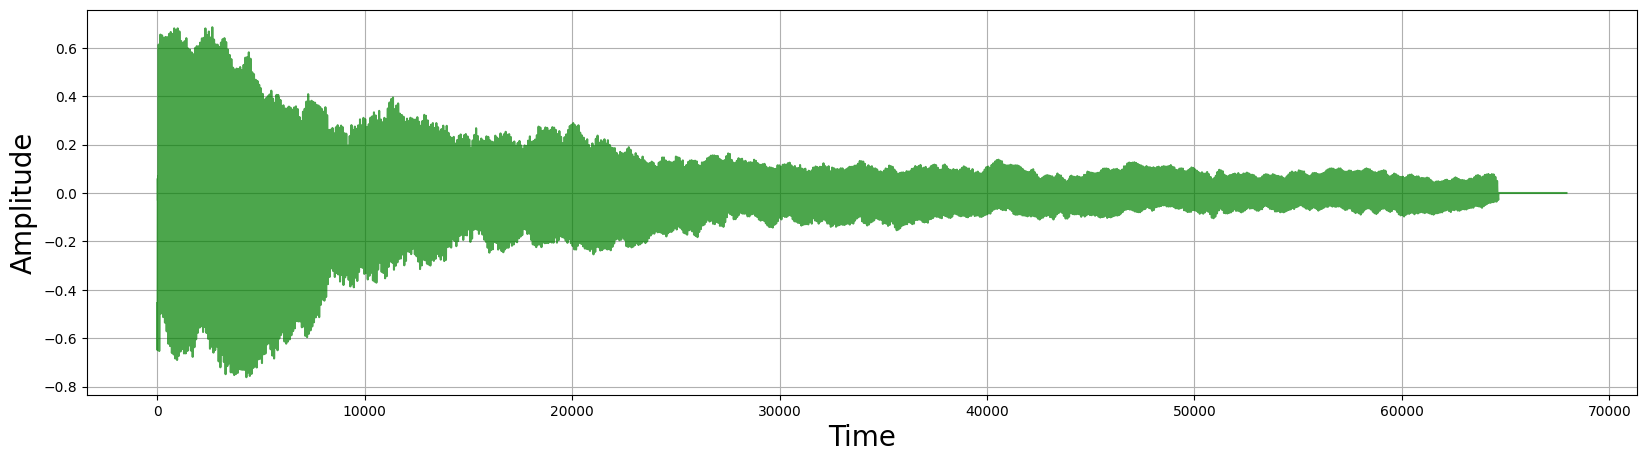

In [7]:
visualize_audio(wav, sr)

Теперь разберем, как перейти от time-domain во frequency-domain

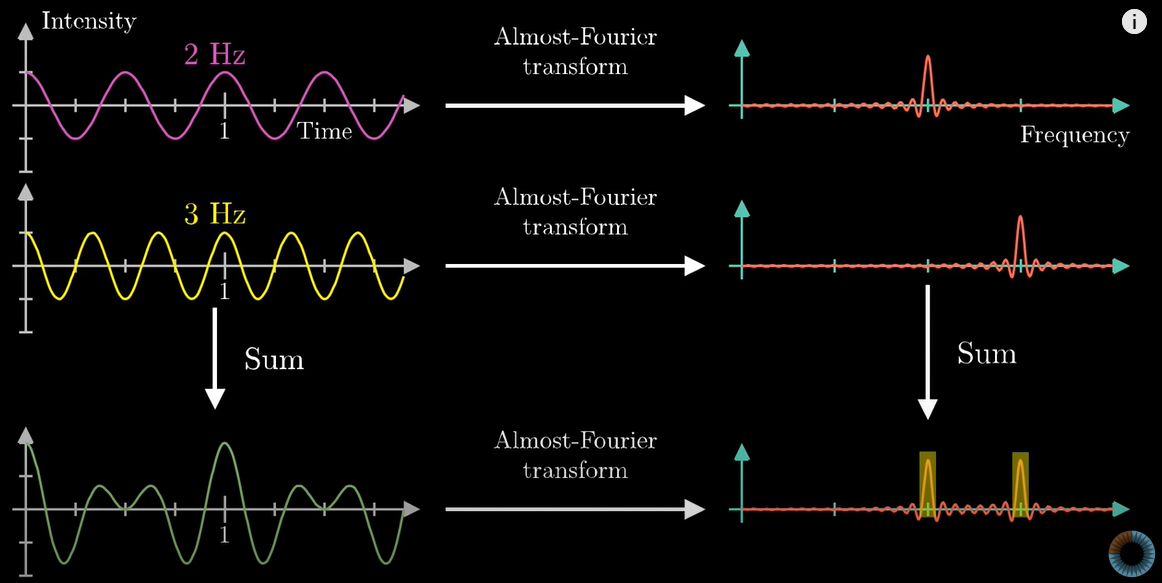

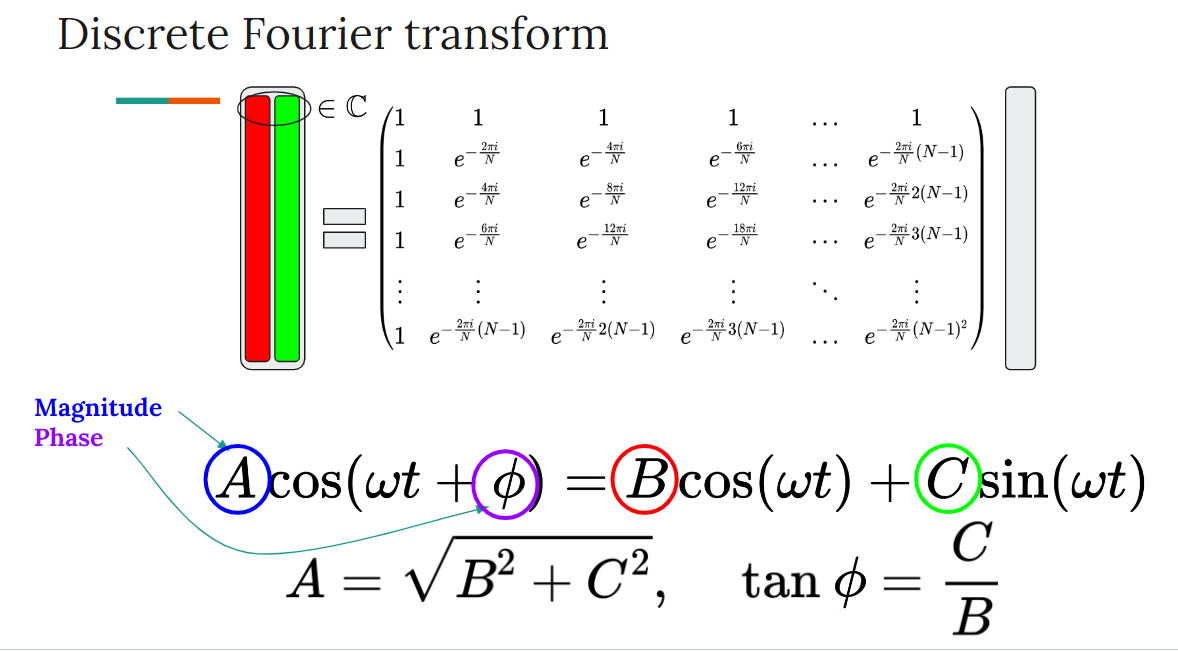

In [8]:
n_fft = 1024
ft = torch.fft.fft(wav.mean(dim=0), n=n_fft)

In [11]:
magnitude = ft.abs().pow(2)
frequency = np.linspace(0, sr, len(magnitude))

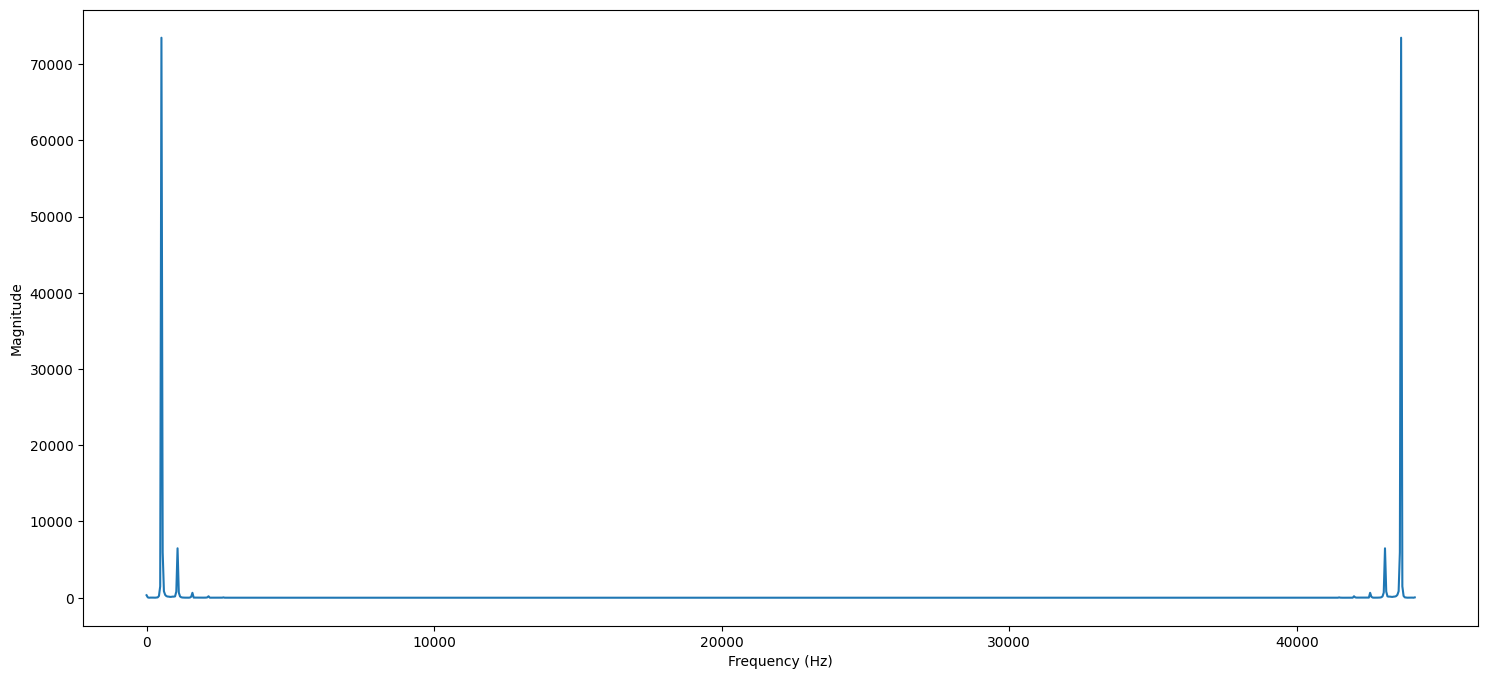

In [ ]:
# plot spectrum
plt.figure(figsize=(18, 8))
plt.plot(frequency, magnitude) # magnitude spectrum
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()

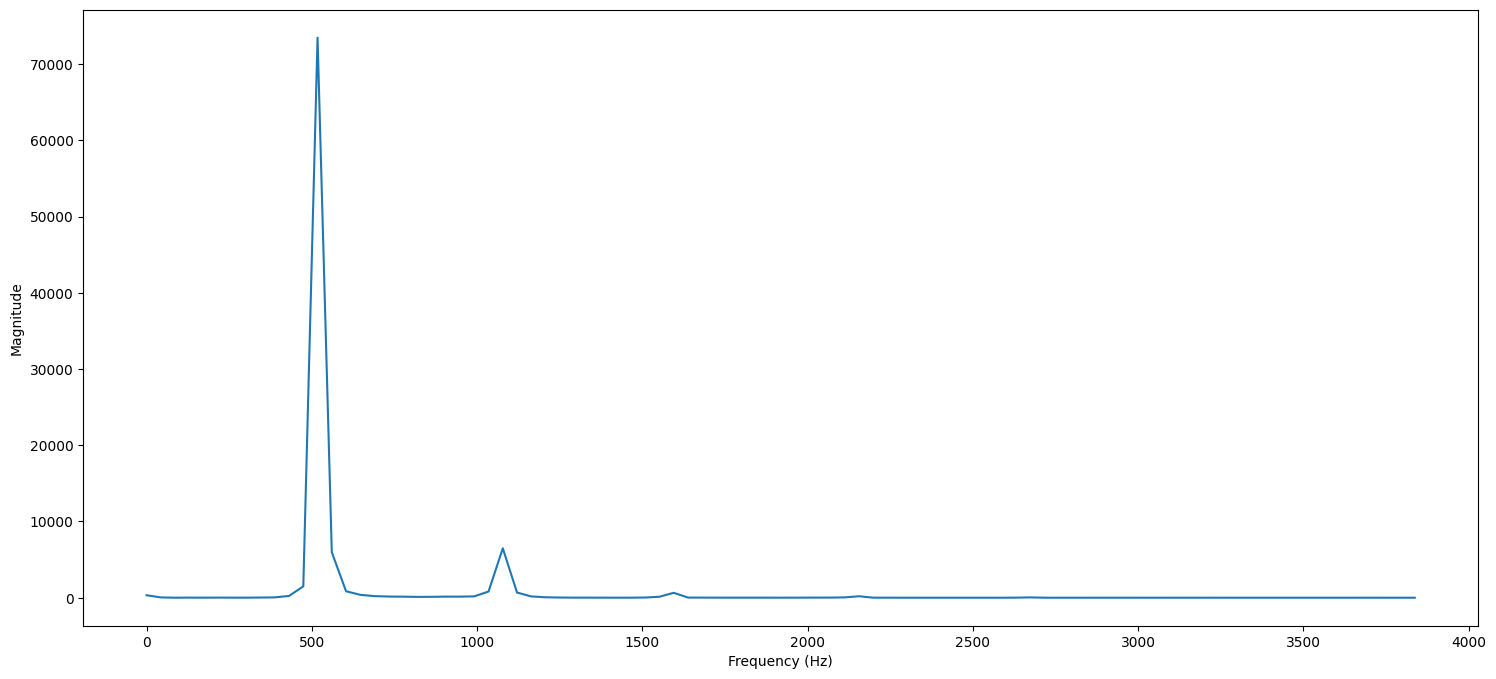

In [ ]:
# plot spectrum
plt.figure(figsize=(18, 8))
plt.plot(frequency[:90], magnitude[:90]) # magnitude spectrum
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()

### Build mel spectrogram

Теперь разберем, как нам получить мел-спектрограмму

In [20]:
wav, sr = torchaudio.load('example.wav')

In [21]:
display.Audio(wav, rate=sr)

In [22]:
n_fft = 1024

In [23]:
spectrum = torch.fft.rfft(wav, n=n_fft)

In [25]:
spectrogram = spectrum.abs().pow(2)

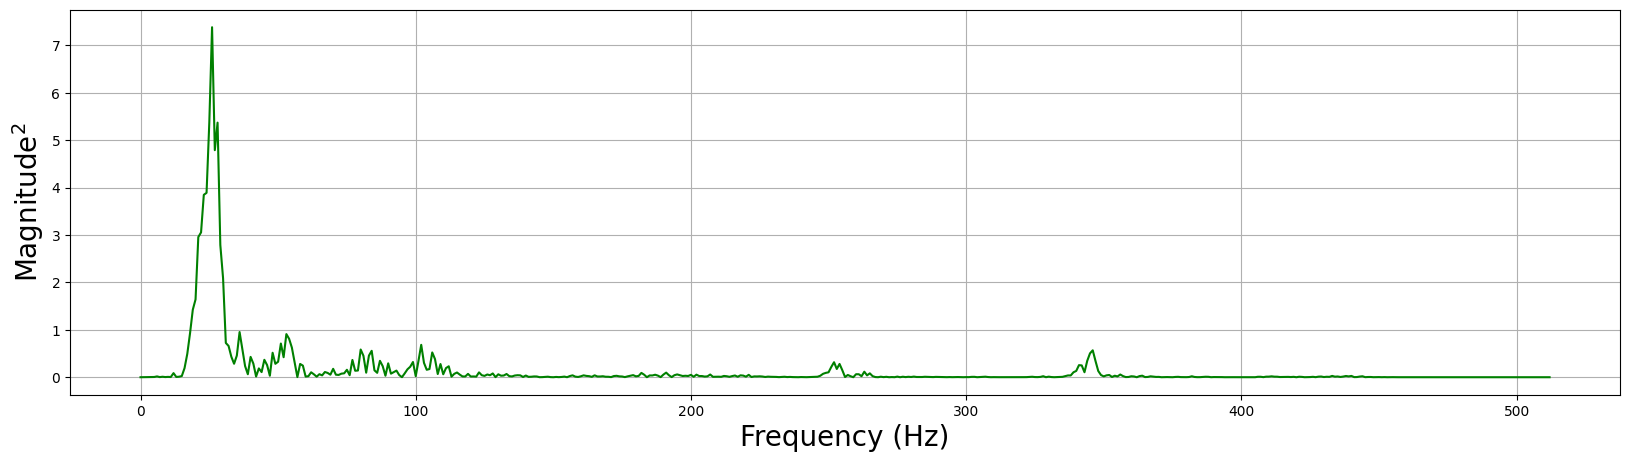

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(spectrogram.squeeze(), c='green')
plt.grid()
plt.xlabel('Frequency (Hz)', size=20)
plt.ylabel('Magnitude$^2$', size=20)
plt.show()


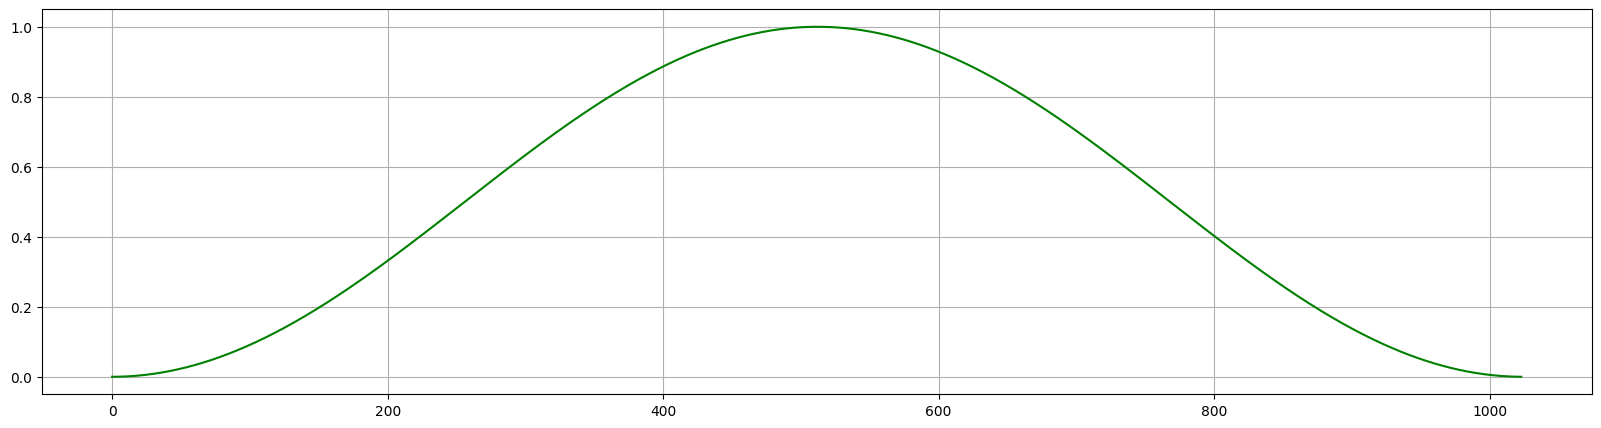

In [ ]:
window_size = n_fft
window = torch.hann_window(window_size)

plt.figure(figsize=(20, 5))
plt.plot(window, c='green')
plt.grid()
plt.show()


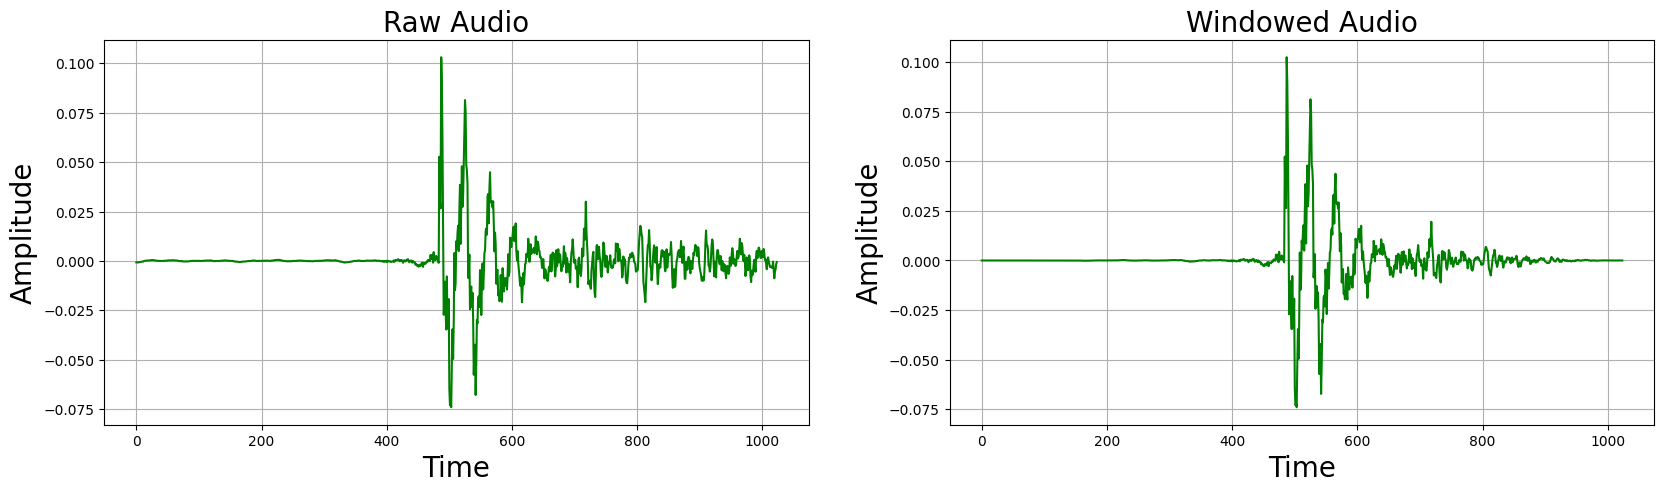

In [ ]:
clipped_wav = wav[:, :window_size]
windowed_clipped_wav = window * clipped_wav

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].plot(clipped_wav.squeeze(), c='green')
axes[0].set_title('Raw Audio', size=20)

axes[1].plot(windowed_clipped_wav.squeeze(), c='green')
axes[1].set_title('Windowed Audio', size=20)

for i in range(2):
    axes[i].grid()
    axes[i].set_xlabel('Time', size=20)
    axes[i].set_ylabel('Amplitude', size=20)

plt.show()


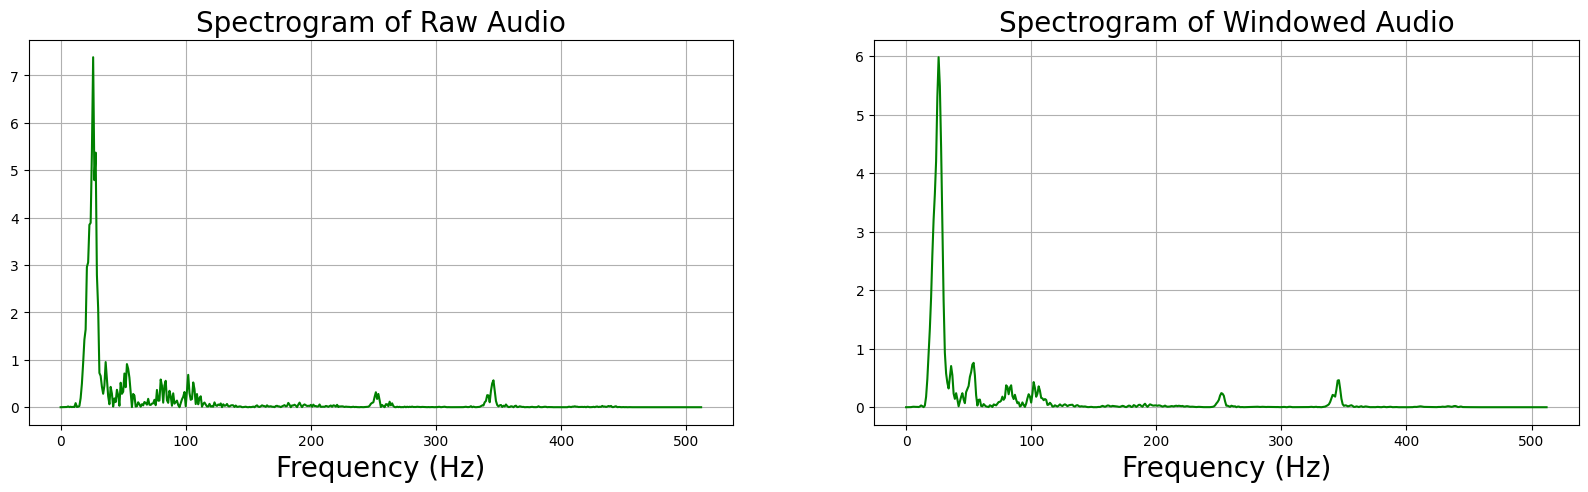

In [ ]:
spectrogram = torch.fft.rfft(clipped_wav).abs().pow(2)
windowed_spectrogram = torch.fft.rfft(windowed_clipped_wav).abs().pow(2)

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].plot(spectrogram.squeeze(), c='green')
axes[0].set_title('Spectrogram of Raw Audio', size=20)

axes[1].plot(windowed_spectrogram.squeeze(), c='green')
axes[1].set_title('Spectrogram of Windowed Audio', size=20)

for i in range(2):
    axes[i].grid()
    axes[i].set_xlabel('Frequency (Hz)', size=20)

plt.show()


In [34]:
spectrum = torch.stft(
    wav,
    n_fft=1024,
    hop_length=256,
    win_length=1024,
    window=torch.hann_window(1024),

    # We don't want to pad input signal
    center=False,

    # Take first (n_fft // 2 + 1) frequencies
    onesided=True,

    # Apply torch.view_as_real on each window
    return_complex=False,
)

In [35]:
spectrogram = spectrum.norm(dim=-1).pow(2)
spectrogram.shape

torch.Size([1, 513, 828])

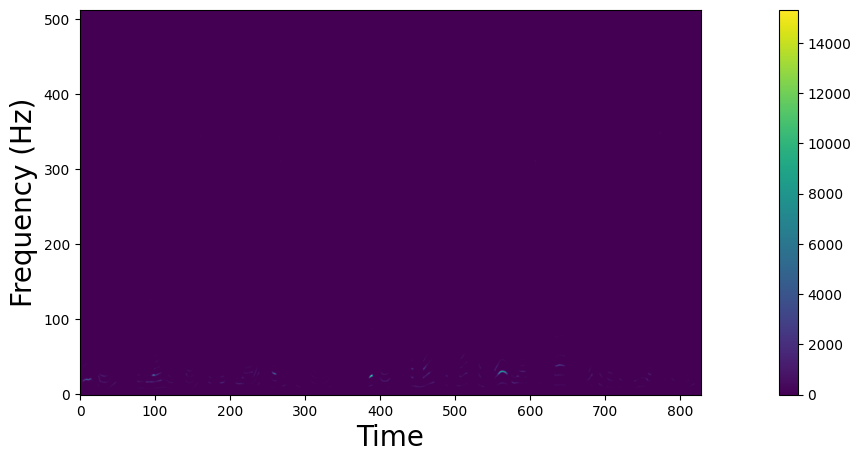

In [43]:
plt.figure(figsize=(20, 5))
plt.imshow(spectrogram.squeeze().data.numpy())
plt.xlabel('Time', size=20)
plt.ylabel('Frequency (Hz)', size=20)
plt.gca().invert_yaxis()
plt.colorbar()

plt.show()

Нужно логарифмировать

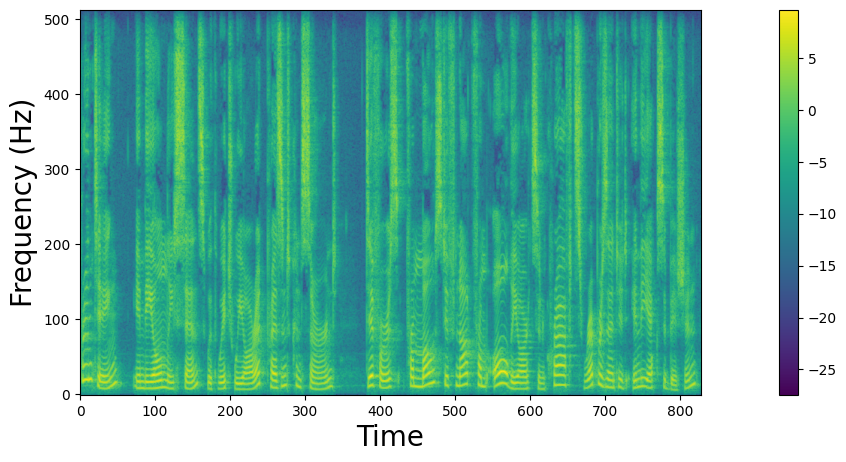

In [42]:
plt.figure(figsize=(20, 5))
plt.imshow(spectrogram.squeeze().log().data.numpy())
plt.xlabel('Time', size=20)
plt.ylabel('Frequency (Hz)', size=20)
plt.gca().invert_yaxis()
plt.colorbar()

plt.show()

Нужно привести к нужной шкале, как воспринимает человеческое ухо

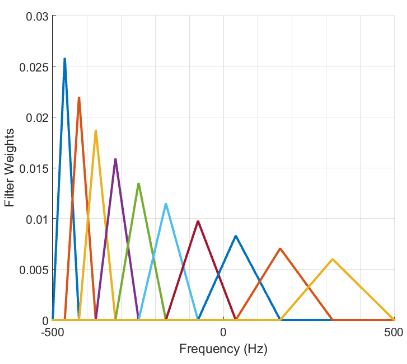

In [44]:
mel_scaler = torchaudio.transforms.MelScale(
    n_mels=80,
    sample_rate=sr,
    n_stft=n_fft // 2 + 1
)

In [45]:
mel_scaler.fb.shape

torch.Size([513, 80])

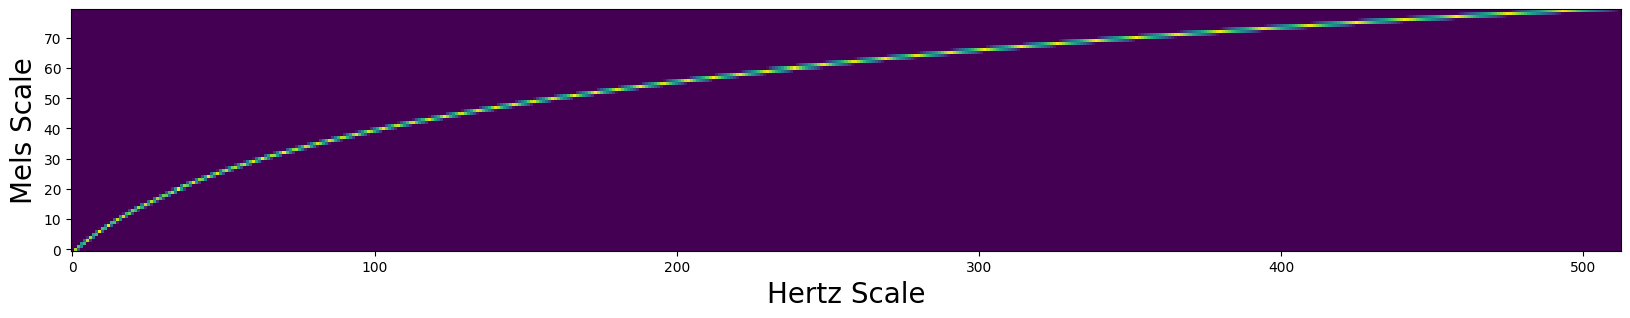

In [46]:
plt.figure(figsize=(20, 5))
plt.imshow(mel_scaler.fb.T)
plt.xlabel('Hertz Scale', size=20)
plt.ylabel('Mels Scale', size=20)
plt.gca().invert_yaxis()
plt.show()

In [47]:
mel_spectrogram = mel_scaler(spectrogram)

In [48]:
mel_spectrogram.shape

torch.Size([1, 80, 828])

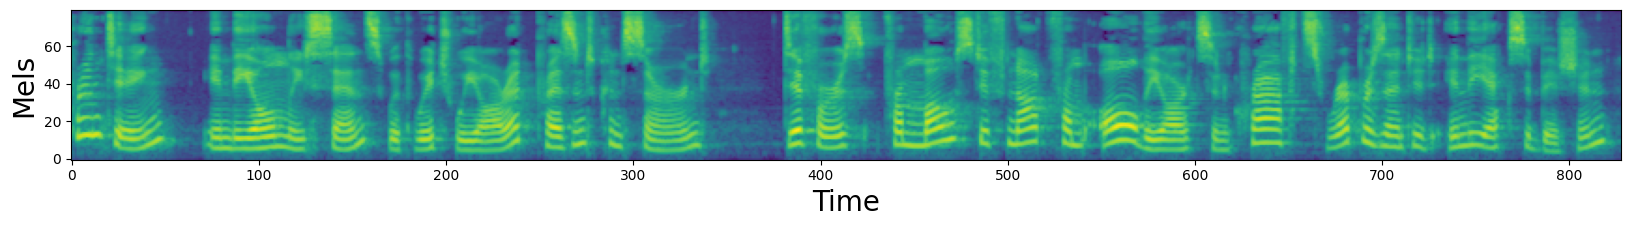

In [49]:
plt.figure(figsize=(20, 5))
plt.imshow(mel_spectrogram.squeeze().log())
plt.xlabel('Time', size=20)
plt.ylabel('Mels', size=20)
plt.gca().invert_yaxis()
plt.show()

In [51]:
featurizer = torchaudio.transforms.MelSpectrogram(
            sample_rate=sr,
            n_fft=1024,
            win_length=1024,
            hop_length=256,
            n_mels=80,
            center=False,
        )

In [52]:
assert torch.allclose(mel_spectrogram, featurizer(wav))

## Audio mnist classification



Разберем, как работать со звуком в Deep Learning на примере классификации аудио дорожек. Будем работать с датасетом Audio MNIST, обучим 3 модели: модель на сырой аудиоволне, на мел спектрограмме и на фичах из предобученной модели Wav2Vec.

![](https://i.imgur.com/OX1ADxu.png)

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ouSOru91p-ZJCyI6E8cGh7N0r3vffi06' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ouSOru91p-ZJCyI6E8cGh7N0r3vffi06" -O AudioMNIST.zip && rm -rf /tmp/cookies.txt
!unzip -q AudioMNIST.zip

In [ ]:
!pip install transformers

In [55]:
from typing import List, Tuple

import pathlib
from tqdm import tqdm
from itertools import islice
from collections import defaultdict

import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, Subset

import transformers

Определим класс AudioMnistDataset для загрузки данных. При загрузке извлечем из названия файла label аудио - произносимую цифру - первый символ в аудио до знака "_"



In [56]:
class AudioMnistDataset(Dataset):
    SR = 16_000

    """
    Each wavfile has the following format: digit_speackerid_wavid.wav
        For example, 6_01_47.wav:
            6 -- the number 6 is spoken
            01 -- the number is spoken by 1 speaker
            47 -- id of wavfile
    """

    def __init__(self, path_to_data: str):
        self.path_to_data = pathlib.Path(path_to_data)
        self.paths = list(self.path_to_data.rglob('?_*_*.wav'))

    def __getitem__(self, index: int):
        path_to_wav = self.paths[index].as_posix()

        # Load wav
        wav, sr = torchaudio.load(path_to_wav)

        label = int(path_to_wav.split('/')[-1].split('_')[0])

        return wav, label

    def __len__(self):
        return len(self.paths)


In [57]:
dataset = AudioMnistDataset('AudioMNIST')

In [ ]:
wav, label = dataset[123]
label

8

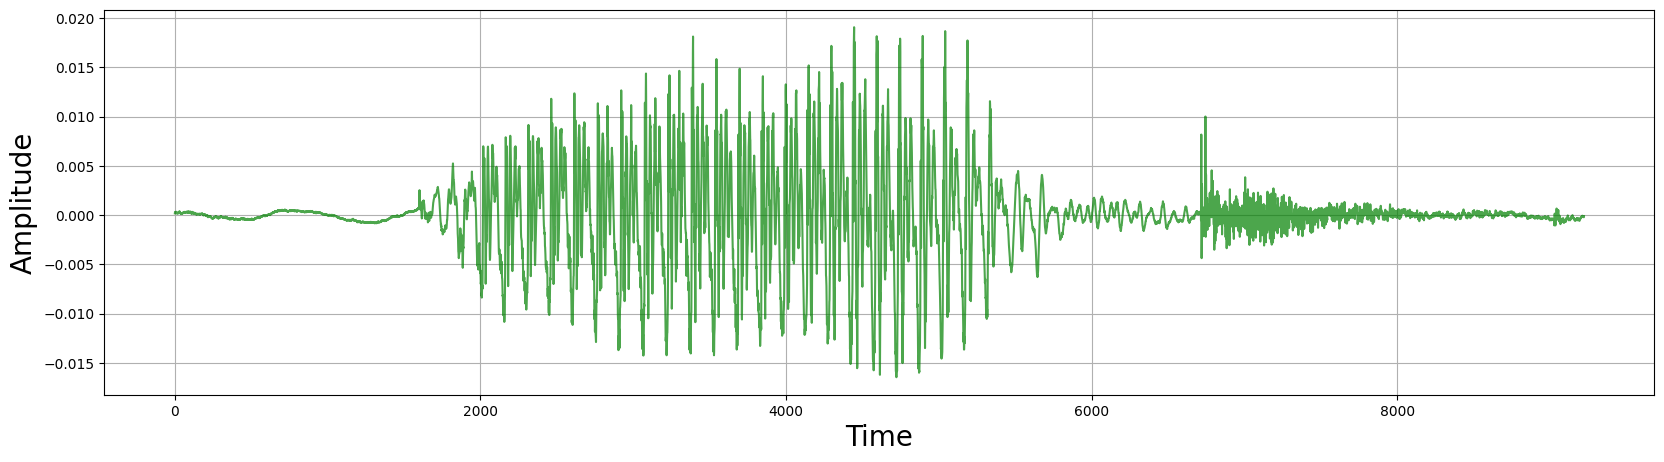

In [ ]:
visualize_audio(wav, sr=dataset.SR)

Разобъем датасет на датасеты для трейна и валидации.



In [58]:
train_ratio = 0.9
train_size = int(len(dataset) * train_ratio)
validation_size = len(dataset) - train_size

indexes = torch.randperm(len(dataset))
train_indexes = indexes[:train_size]
validation_indexes = indexes[train_size:]

train_dataset = Subset(dataset, train_indexes)
validation_dataset = Subset(dataset, validation_indexes)

In [ ]:
assert not set(train_indexes.tolist()).intersection(set(validation_indexes.tolist()))

Класс Collator объединяет аудиодорожки в один батч. Так как в нашей задаче все аудио разной длины, для того чтобы собрать в батч, заполним недостающее нулями (сделаем паддинг). Для этого создадим тензор из нулей размера [batch_size, max_wav_len] и заполним его элементами батча.



In [59]:
class Collator:

    def __call__(self, batch: List[Tuple[torch.Tensor, int]]):
        lengths = []
        wavs, labels = zip(*batch)

        for wav in wavs:
            lengths.append(wav.size(-1))

        max_len = max(lengths)
        batch_wavs = torch.zeros(len(batch), max_len)
        for i, wav in enumerate(wavs):
          batch_wavs[i, :lengths[i]] = wav

        labels = torch.tensor(labels).long()
        lengths = torch.tensor(lengths).long()

        return {
            'wav': batch_wavs,
            'label': labels,
            'length': lengths,
        }


In [60]:
train_dataloader = DataLoader(
    train_dataset, batch_size=32,
    shuffle=True, collate_fn=Collator(),
    num_workers=2, pin_memory=True
)

validation_dataloader = DataLoader(
    validation_dataset, batch_size=32,
    collate_fn=Collator(),
    num_workers=2, pin_memory=True
)

In [ ]:
next(iter(train_dataloader))["wav"].shape

torch.Size([32, 14677])

### Raw wav model

В модель приходит батч размера [batch_size, 1, seq_len].

Последний слой - слой для классификации, возвращающий тензор размера [batch_size, NUM_CLASSES].

In [ ]:
class AudioClassifier(nn.Module):

    def __init__(self, input_dim, num_channels):
        super().__init__()
        self.input_dim = input_dim
        self.num_channels = num_channels
        self.convs = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=num_channels, kernel_size=17, stride=1),
            nn.BatchNorm1d(num_channels),
            nn.ReLU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, kernel_size=11, stride=2),
            nn.BatchNorm1d(num_channels),
            nn.ReLU(),
                      )
        self.clf = nn.Linear(in_features=num_channels, out_features=10)

    def forward(self, inputs, length=None):
        # inputs of shape [batch_size, 1, seq_len]
        x = # convolutions
        x = # pooling
        x = # fully-connected classifier
        return x

Зададим параметры модели и оптимизатора и функцию потерь

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

raw_wav_model = AudioClassifier(input_dim=1, num_channels=32).to(device)

optimizer = optim.Adam(raw_wav_model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

Создадим класс для подсчета метрики

In [ ]:
class AverageMeter(object):
    """
    Computes and stores the average and current value
    """

    def __init__(self):
        self.reset()


    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

Напишем функцию для обучения

In [ ]:
def train_model(model, train_dataloader, validation_dataloader, run_model, num_epoch=10, storage=defaultdict(list), device="cpu"):
    for epoch in range(num_epoch):
        train_loss_meter = AverageMeter()
        print(f"Epoch {epoch} out of {num_epoch}")

        model.train()
        for i, batch in enumerate(tqdm(train_dataloader)):
            label = batch['label'].to(device)
            # feed model
            output = run_model(model, batch, mode="train", device=device)

            # compute loss
            loss = criterion(output, label)

            # zero out previously computed gradients
            optimizer.zero_grad()

            # compute gradients
            loss.backward()

            # update weights
            optimizer.step()

            # update metrics
            train_loss_meter.update(loss.item())

        storage['train_loss'].append(train_loss_meter.avg)

        validation_loss_meter = AverageMeter()
        validation_accuracy_meter = AverageMeter()

        model.eval()
        for i, batch in islice(enumerate(tqdm(validation_dataloader)), 1):
            label = batch['label'].to(device)
            output = run_model(model, batch, mode="eval", device=device)
            loss = criterion(output, label)

            # compute accuracy
            matches = (output.argmax(dim=-1) == label).float().mean()

            validation_loss_meter.update(loss.item())
            validation_accuracy_meter.update(matches.item())

        storage['validation_loss'].append(validation_loss_meter.avg)
        storage['validation_accuracy'].append(validation_accuracy_meter.avg)

        display.clear_output()

        fig, axes = plt.subplots(1, 3, figsize=(20, 5))

        axes[0].plot(storage['train_loss'], label='train_loss')
        axes[1].plot(storage['validation_loss'], label='validation_loss')

        axes[2].plot(storage['validation_accuracy'], label='validation_accuracy')

        for i in range(3):
            axes[i].grid()

            axes[i].legend()

        plt.show()

In [ ]:
def run_model(model, batch, mode="eval", device="cpu"):
    wav = batch['wav'].to(device)
    length = batch['length'].to(device)

    if mode == "train":
        return model(wav.unsqueeze(1), length)
    else:
        with torch.no_grad():
            return model(wav.unsqueeze(1), length)

In [ ]:
train_model(raw_wav_model, train_dataloader, validation_dataloader, run_model, device=device)

Напишем функцию для инференса

In [ ]:
def inference(model, wav, device="cpu", sr=16000):
    """
    Display wav and results of NN
    """
    output = # your code here
    print(f"Predicted class: {output.argmax(dim=-1).item()}")
    visualize_audio(wav, sr=sr)

Проверим на сэмпле из валидационной выборки

In [65]:
batch = next(iter(validation_dataloader))

In [ ]:
inference(raw_wav_model, batch["wav"][0].unsqueeze(0), device=device, sr=dataset.SR)

Проверим на своей записи

In [ ]:
!sudo apt install ffmpeg
!pip install torchaudio ipywebrtc notebook
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
from ipywebrtc import AudioRecorder, CameraStream
import torchaudio
from IPython.display import Audio
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
camera = CameraStream(constraints={'audio': True,'video':False})
recorder = AudioRecorder(stream=camera)
recorder

In [ ]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav file.wav -y -hide_banner -loglevel panic
sig, sr = torchaudio.load("file.wav")
print(sig.shape)
Audio(data=sig, rate=sr)

In [ ]:
wav = torchaudio.functional.resample(sig, orig_freq=sr, new_freq=dataset.SR)
wav.shape

In [ ]:
inference(raw_wav_model, wav, device=device, sr=dataset.SR)

### Mel spectrogram model

Класс Featurizer делает необходимый в нашей задаче препроцессинг - считаем мел спектрограмму, логарифмирует ее и считает длину спектрограммы.



In [ ]:
NUM_MELS = 80
HOP_LEN = 256
N_FFT = 1024
WIN_LEN = N_FFT
SAMPLE_RATE = 16000

In [ ]:
class Featurizer(nn.Module):

    def __init__(self):
        super(Featurizer, self).__init__()

        self.featurizer = torchaudio.transforms.MelSpectrogram(
            sample_rate=SAMPLE_RATE,
            n_fft=N_FFT,
            win_length=WIN_LEN,
            hop_length=HOP_LEN,
            n_mels=NUM_MELS,
            center=True,
        )

    def forward(self, wav, length=None):
        mel_spectrogram = self.featurizer(wav)
        mel_spectrogram = mel_spectrogram.clamp(min=1e-5).log()

        if length is not None:
            length = (length - self.featurizer.win_length) // self.featurizer.hop_length
            length += (self.featurizer.win_length // self.featurizer.hop_length)

            return mel_spectrogram, length

        return mel_spectrogram


Зададим параметры модели и оптимизатора и функцию потерь



In [ ]:
mel_model = AudioClassifier(input_dim=NUM_MELS, num_channels=32).to(device)
featurizer = Featurizer().to(device)

optimizer = optim.Adam(mel_model.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
def run_model(model, featurizer, batch, mode="eval", device="cpu"):
    wav = batch['wav'].to(device)
    length = batch['length'].to(device)

    return  # your code here

In [ ]:
train_model(mel_model, train_dataloader, validation_dataloader, run_model, device=device)

In [ ]:
def inference(model, featurizer, wav, length=None, device="cpu", sr=16000):
    """
    Display wav and results of NN
    """
    output = # your code here
    print(f"Predicted class: {output.argmax(dim=-1).item()}")
    visualize_audio(wav, sr=sr)


In [ ]:
inference(mel_model, featurizer, batch["wav"][0].unsqueeze(0), length=batch["length"][0].unsqueeze(0), device=device, sr=dataset.SR)

In [ ]:
inference(mel_model, featurizer, wav, device=device, sr=dataset.SR)

### Wav2Vec

Можно использовать модель, которая хорошо кодирует звук

In [63]:
model_name = "facebook/wav2vec2-base"

In [61]:
processor = transformers.Wav2Vec2FeatureExtractor(
    feature_size=1,
    sampling_rate=sr,
    padding_value=0.0,
    do_normalize=True,
    return_attention_mask=True,
)

In [ ]:
model = transformers.Wav2Vec2Model.from_pretrained(
            model_name,
            attention_dropout=0.01,
            hidden_dropout=0.01,
            feat_proj_dropout=0.0,
            mask_time_prob=0.05,
            layerdrop=0.01,
        )

In [79]:
batch_wav = batch["wav"]

In [80]:
features = processor(batch_wav,sampling_rate=sr, return_tensors="pt")

In [82]:
output = model(input_values=features["input_values"][0])

А теперь все соберем

In [ ]:
class Wav2VecFeaturizer(nn.Module):

    def __init__(self, model_name, sampling_rate=16000):
        super(Wav2VecFeaturizer, self).__init__()

        self.processor = transformers.Wav2Vec2FeatureExtractor(
            feature_size=1,
            sampling_rate=sr,
            padding_value=0.0,
            do_normalize=True,
            return_attention_mask=True,
        )
        self.sr = sr

    def forward(self, batch, length=None):
        features = self.processor(batch, sampling_rate=self.sr, return_tensors="pt")["input_values"]
        if length:
            batch_wavs = torch.zeros(features.shape[-2], features.shape[-1], dtype=features.dtype)
            for i, feat in enumerate(features[0]):
                batch_wavs[i, :length[i]] = feat[:length[i]]
                return batch_wavs
        else:
            return features[0]

In [ ]:
class AudioClassifier(nn.Module):
    def __init__(
        self,
        model_name,
        num_classes=10,
        sampling_rate=16000,
    ) -> None:
        super().__init__()

        self.model = transformers.Wav2Vec2Model.from_pretrained(
            model_name,
            attention_dropout=0.01,
            hidden_dropout=0.01,
            feat_proj_dropout=0.0,
            mask_time_prob=0.05,
            layerdrop=0.01,
        )
        self.classifier = torch.nn.Linear(self.model.config.hidden_size, num_classes)
        self.sampling_rate = sampling_rate

    def forward(self, x) -> torch.Tensor:
        x = # get hidden features
        x = # pooling
        x = # fully-connected classifier
        return x

In [ ]:
wav2vec_model = AudioClassifier(model_name).to(device)
featurizer = Wav2VecFeaturizer(model_name).to(device)

optimizer = optim.Adam(wav2vec_model.parameters(), lr=1e-5, weight_decay=0.06)

In [ ]:
def run_model(model, batch, mode="eval", device="cpu"):
    wav = batch['wav']
    length = batch['length']
    features = featurizer(wav, length)

    if mode == "train":
        return model(features.to(device))
    else:
        with torch.no_grad():
            return model(features.to(device))

In [ ]:
train_model(wav2vec_model, train_dataloader, validation_dataloader, run_model, device=device, num_epoch=4)

In [ ]:
def inference(model, featurizer, wav, length=None, device="cpu", sr=16000):
    """
    Display wav and results of NN
    """
    output = # your code here
    print(f"Predicted class: {output.argmax(dim=-1).item()}")
    visualize_audio(wav, sr=sr)

In [ ]:
inference(wav2vec_model, featurizer, batch["wav"][0].unsqueeze(0), length=batch["length"][0].unsqueeze(0), device=device, sr=dataset.SR)

In [ ]:
inference(wav2vec_model, featurizer, wav, device=device, sr=dataset.SR)

## Домашнее задание

1. Дописать функции инференса для модели, обученной на мел-спектрограмме, и для модели Wav2Vec.
2. Реализовать еще один вариант модели с Wav2Vec: в Featurizer получить эмбеддинги из предобученной замороженной модели Wav2Vec и на них обучить отдельный классификатор (как с мел спектрограммой)

Напоминаю, что отправлять задание на проверку и задавать вопросы вы можете мне в телеграме @Julia_Korot до следующей пары 25.10.2023.